In [1]:
from copy import deepcopy
import heapq
import itertools

Original Graph Edges:
[(1, 2), (1, 4), (2, 3), (3, 4)]
Adding edge (1, 3) to break chordless cycle: [1, 2, 3, 4]

Chordal Graph Edges:
[(1, 2), (1, 4), (1, 3), (2, 3), (3, 4)]


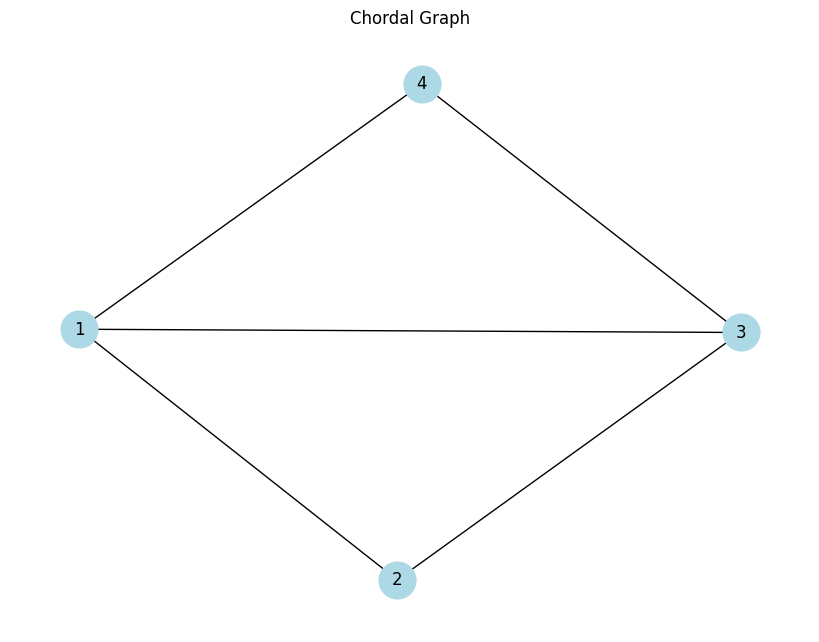

In [3]:
import networkx as nx
from itertools import combinations


def is_chordal(graph):
    """
    Check if the graph is chordal using the Lex-BFS algorithm.
    """
    try:
        # NetworkX provides a chordality test
        nx.find_cycle(graph, orientation='ignore')
        return False
    except nx.NetworkXNoCycle:
        return True


def find_chordless_cycle(graph):
    """
    Find a chordless cycle in the graph (length > 3) if one exists.
    """
    nodes = list(graph.nodes())
    for cycle_length in range(4, len(nodes) + 1):
        for cycle_nodes in combinations(nodes, cycle_length):
            subgraph = graph.subgraph(cycle_nodes)
            if nx.is_connected(subgraph) and len(subgraph.edges()) == cycle_length:
                # Check if it is chordless (no additional edges in subgraph)
                if all(not graph.has_edge(cycle_nodes[i], cycle_nodes[j])
                       for i in range(cycle_length) for j in range(i + 2, cycle_length) if (i != 0 or j != cycle_length - 1)):
                    return list(cycle_nodes)
    return None


def choose_edge_to_add(cycle, graph):
    """
    Choose a minimal fill-in edge to add.
    """
    best_edge = None
    min_fill = float('inf')

    for u, v in combinations(cycle, 2):
        if not graph.has_edge(u, v):
            # Simulate adding the edge and count new triangles
            added_fill = sum(1 for w in graph.neighbors(u) if graph.has_edge(w, v))
            if added_fill < min_fill:
                best_edge = (u, v)
                min_fill = added_fill

    return best_edge


def make_chordal(graph):
    """
    Triangulate the graph by adding minimal fill-in edges.
    """
    graph = graph.copy()

    while not is_chordal(graph):
        cycle = find_chordless_cycle(graph)
        if not cycle:
            break
        
        u, v = choose_edge_to_add(cycle, graph)
        print(f"Adding edge ({u}, {v}) to break chordless cycle: {cycle}")
        graph.add_edge(u, v)

    return graph


if __name__ == "__main__":
    # Example graph (with chordless cycle)
    G = nx.Graph()
    edges = [(1, 2), (2, 3), (3, 4), (1,4)]  # A sample non-chordal graph
    G.add_edges_from(edges)

    print("Original Graph Edges:")
    print(G.edges())

    chordal_graph = make_chordal(G)

    print("\nChordal Graph Edges:")
    print(chordal_graph.edges())

    # Draw the graph
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(chordal_graph)
    nx.draw(chordal_graph, pos, with_labels=True, node_size=700, node_color='lightblue')
    plt.title("Chordal Graph")
    plt.show()


In [2]:
def adjacency_list(edge_list, node_list):
    """
    edge_set = set()
    for u,v in edge_list:
        edge_set.add(u)
        edge_set.add(v)
    n = len(edge_set)
    """
    adj_list = {i: [] for i in node_list}
    for u, v in edge_list:
        adj_list[u].append(v)
        adj_list[v].append(u)
    return adj_list

In [3]:
edge_list = [(0,1), (1, 2), (2, 3), (3, 4), (1,4)]
adjacency_list(edge_list, [0, 1, 2, 3, 4])

{0: [1], 1: [0, 2, 4], 2: [1, 3], 3: [2, 4], 4: [3, 1]}

In [4]:
def is_simplicial(adj_list, node):
    for i in adj_list[node]:
        for j in adj_list[node]:
            if i != j and j not in adj_list[i]:
                return False
    
    return True


In [5]:
def find_simplicial_vertices(adj_list):
    for node in adj_list:
        if(is_simplicial(adj_list, node)):
            return node

In [6]:
def make_vertex_simplicial(adj_list, node):
    for i in adjacency_list(node):
        for j in adjacency_list(node):
            if i != j and j not in adj_list[i]:
                adj_list[i].append(j)
                adj_list[j].append(i)
    return adj_list

In [7]:
def make_chordal_graph(adj_list):
    adj_list2 = deepcopy(adj_list)

    elimination_order = []
    cliques = []

    while len(elimination_order) < len(adj_list):
        simpl_vertex = find_simplicial_vertices(adj_list2)
        if(simpl_vertex):
            elimination_order.append(simpl_vertex)
            clique = {simpl_vertex}
            neighbours = adj_list[simpl_vertex]
            for neigh in neighbours:
                if all(neigh in adj_list[i] for i in clique):
                    clique.add(neigh)
            key = 0
            for cl in cliques:
                if clique.issubset(cl):
                    key = 1
            if key == 0:
                cliques.append(clique)
            for i in adj_list2[simpl_vertex]:
                adj_list2[i].remove(simpl_vertex)
            del adj_list2[simpl_vertex]
        else:
            degrees = {node: len(neighbors) for node, neighbors in adj_list2.items()}
            least_degree_node = min(degrees, key=degrees.get)

            for i in adj_list2[least_degree_node]:
                for j in adj_list2[least_degree_node]:
                    if i != j and j not in adj_list2[i]:
                        adj_list2[i].append(j)
                        adj_list2[j].append(i)
                        adj_list[i].append(j)
                        adj_list[j].append(i)
            elimination_order.append(least_degree_node)
            clique = {least_degree_node}
            neighbours = adj_list[least_degree_node]
            for neigh in neighbours:
                if all(neigh in adj_list[i] for i in clique):
                    clique.add(neigh)
            key = 0
            for cl in cliques:
                if clique.issubset(cl):
                    key = 1
            if key == 0:
                cliques.append(clique)
            for i in adj_list2[least_degree_node]:
                adj_list2[i].remove(least_degree_node)
            del adj_list2[least_degree_node]
    
    return adj_list, elimination_order, cliques


In [8]:
edge_list = [(0,1), (1, 2), (2, 3), (3, 0), (0,4)]
a = adjacency_list(edge_list, [0, 1, 2, 3, 4])
a,e,m = make_chordal_graph(a)

print(a)
print(e)
print(m)

{0: [1, 3, 4], 1: [0, 2, 3], 2: [1, 3], 3: [2, 0, 1], 4: [0]}
[4, 0, 1, 2, 3]
[{0, 4}, {0, 1, 3}, {1, 2, 3}]


In [9]:
def find_max_cliques(adj_list, elimination_order):
    cliques = []
    max_cliques = []
    for node in elimination_order:
        neighbours = adj_list[node]
        clique ={node}
        for neigh in neighbours:
            if all([neigh in adj_list[cl] for cl in clique]):
                clique.add(neigh)
        cliques.append(clique)
    
    max_len = max(len(i) for i in cliques)
    for clique in cliques:
        if len(clique) == max_len:
            if clique not in max_cliques:
                max_cliques.append(clique)
    return max_cliques

In [10]:
def create_junction_graph(cliques):
    junc_graph = {}
    for i, cl in enumerate(cliques):
        for j, cl1 in enumerate(cliques):
            if(i < j):
                intersection = cl.intersection(cl1)
                if intersection:
                    if tuple(cl) not in junc_graph:
                        junc_graph[tuple(cl)] = []
                    if tuple(cl1) not in junc_graph:
                        junc_graph[tuple(cl1)] = []

                    junc_graph[tuple(cl)].append((tuple(cl1), len(intersection)))
                    junc_graph[tuple(cl1)].append((tuple(cl), len(intersection)))
    return junc_graph

In [11]:
p = create_junction_graph(m)
p

{(0, 4): [((0, 1, 3), 1)],
 (0, 1, 3): [((0, 4), 1), ((1, 2, 3), 2)],
 (1, 2, 3): [((0, 1, 3), 2)]}

In [12]:
def create_junction_tree(junc_graph):
    edges = []
    for node, neigh in junc_graph.items():
        for n, w in neigh:
            edges.append((node, n, w))
    edges.sort(key=lambda x: -x[2])

    parent = {}
    rank = {}

    def find(node):
        if parent[node] != node:
            parent[node] = find(parent[node])
        return parent[node]
    
    def union(node1, node2):
        root1 = find(node1)
        root2 = find(node2)
        if root1 != root2:
            if rank[root1] > rank[root2]:
                parent[root2] = root1
            else:
                parent[root1] = root2
                if rank[root1] == rank[root2]:
                    rank[root2] += 1
    
    for node in junc_graph:
        parent[node] = node
        rank[node] = 0

    max_spanning_tree = {}
    for node1, node2, weight in edges:
        if find(node1) != find(node2):
            union(node1, node2)
            if node1 not in max_spanning_tree:
                max_spanning_tree[node1] = []
            if node2 not in max_spanning_tree:
                max_spanning_tree[node2] = []
            max_spanning_tree[node1].append(node2)
            max_spanning_tree[node2].append(node1)

    return max_spanning_tree

In [13]:
t = create_junction_tree(p)
t

{(0, 1, 3): [(1, 2, 3), (0, 4)], (1, 2, 3): [(0, 1, 3)], (0, 4): [(0, 1, 3)]}

In [14]:
p = {
    "abc": [("cde", 1), ("acf", 2),("agf",1)],
    "acf": [("abc", 2), ("cde", 1),("agf",2)],
    "cde": [("abc", 1), ("acf", 1)],
    "agf": [("abc", 1), ("gh", 1),("acf",2)],
    "gh": [("agf", 1)]
}
t = create_junction_tree(p)
t

{'abc': ['acf', 'cde'],
 'acf': ['abc', 'agf'],
 'agf': ['acf', 'gh'],
 'cde': ['abc'],
 'gh': ['agf']}

In [15]:
def assign_clique_potential(cliques, potentials):
    max_clique_potentials = {}
    for clique in cliques:
        subset_cliques_potn = []
        for cl in potentials:
            if set(cl).issubset(clique):
                subset_cliques_potn[clique] = potentials[cl]

    max_clique_list = list(clique)
    potn_values = []

    for vals in itertools.product([0,1], repeat=len(max_clique_list)):
        assgmt = dict(zip(max_clique_list, vals))

        potn = 1
        for cl, sclp in subset_cliques_potn.items():
            idx = 0
            for node in cl:
                idx = idx << 1
                idx = idx | assgmt[node]
            potn *= sclp[idx]
        potn_values.append(potn)

    max_clique_potentials[tuple(clique)] = potn_values
    return max_clique_potentials        

In [ ]:
def get_z_values(potentials, max_cliques, junc_tree):
    """"Message Passing Algorithm"""
    def create_empty_message(junc_tree):
        message_dict = {}
        for node in junc_tree:
            message_dict[node] = {}
            for neigh in junc_tree[node]:
                message_dict[node][neigh] = None
        return message_dict
    
    def multiply_messages(potential, message, node, target):
        potential_new = deepcopy(potential) 
        for val in itertools.product([0,1], repeat=len(node)):
            assignmt = dict(zip(node, val))
            targ_idx = 0
            for t in target:
                targ_idx = (targ_idx<<1) + assignmt[t]

            node_idx = 0
            for n in node:
                node_idx = (node_idx<<1) + assignmt[n]

            potential_new[node_idx] *= message[targ_idx]  

        return potential_new
    
    
    
    def send_message(junc_tree, potentials, message_dict):
        def find_leaves(junc_tree):
            leaves = []
            for node in junc_tree:
                if len(junc_tree[node]) == 1:
                    leaves.append(node)
            return leaves
        
        
        dynamic_mem = None
        dynamic_mem = find_leaves(junc_tree)
        for node in dynamic_mem:
            potn = None
            for target in junc_tree[node]:
                if(message_dict[target][node] != None):
                    mes = message_dict[node][target]
                    potn = potentials[tuple(node)]
                    potn = multiply_messages(potn, mes, node, target)
            
            for target in junc_tree[node]:
                if(message_dict[target][node] == None):
                    diff = set(node).difference(target)
                    l = len(diff)
                    message = [1]*(2**(len(junc_tree[node]) - l))
                    potn = potentials[tuple(node)]
                    summing_nodes = set(node).difference(diff)


            message = [1]*len(potentials[node])
            for neigh in junc_tree[node]:
                if neigh != parent:
                    send_message(junc_tree, potentials, message_dict, neigh, node)
                    message = [a*b for a,b in zip(message, message_dict[neigh][node])]
            message_dict[node][parent] = message

In [24]:
j = {
    (1,2) : [((0,1),1)],
    (0,1) : [((1,2),1),((0,3),1)],
    (0,3) : [((0,1),1)]
}
j1 = create_junction_tree(j)

In [25]:
mcp = {
    (1,2): [2,7,1,3],
    (0,1): [3,4,5,6],
    (0,3): [5,8,2,7]
}

In [28]:
k = get_z_values(mcp, [(1,2), (0,1), (0,3)], j1)

TypeError: list indices must be integers or slices, not tuple

In [22]:
k

{(1, 2): [30, 224, 10, 126], (0, 1): [15, 32, 10, 42], (0, 3): [5, 8, 2, 7]}

In [ ]:
def multiply_messages(potential, message, node, target):
        potential_new = deepcopy(potential) 
        for val in itertools.product([0,1], repeat=len(node)):
            assignmt = dict(zip(node, val))
            targ_idx = 0
            for t in target:
                targ_idx = (targ_idx<<1) + assignmt[t]

            node_idx = 0
            for n in node:
                node_idx = (node_idx<<1) + assignmt[n]

            potential_new[node_idx] *= message[targ_idx]  

        return potential_new


In [48]:
multiply_messages([1,2,3,4,5,6,7,8], [1,2,3,4], [0,1,2], [0,2])

1*1=1
2*2=4
3*1=3
4*2=8
5*3=15
6*4=24
7*3=21
8*4=32


[1, 4, 3, 8, 15, 24, 21, 32]

In [ ]:
def condense_message(potential, node, summing_nodes):
    new_potential = []
    for val in itertools.product([0,1], repeat=len(summing_nodes)):
        sum_val = 0
        for val1 in itertools.product([0,1], repeat=len(node)-len(summing_nodes)):
            


    return new_potential

In [50]:
condense_message([1,2,3,4,5,6,7,8], [0,1,2], [2])

[]